In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
df = pd.read_csv('./data/train.csv')

In [4]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    condition = False
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC' and (word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록')):
            condition = True
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            ret.append((word[0], condition, nouns))
            nouns = []
            condition = False
    if len(nouns) > 0:
        ret.append((word[0], condition, nouns))
    return ret

In [5]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-21 20:13:49.795652 0
2019-12-21 20:14:28.646310 100000
2019-12-21 20:15:16.022432 200000


In [6]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [7]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [8]:
cond_test = pd.Series(wc.get_counts('conditioned'))
cond_test[cond_test.index.map(len) > 1].head(5)

첫날        37
누군가      242
행복      7022
문자     24824
라운지      533
dtype: int64

In [9]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

누군가      242
행복      7022
문자     24824
라운지      533
이용     11239
       ...  
대성       125
신전        53
자채        92
자절       316
채팅       503
Length: 1571, dtype: int64

행성        683
팀장      31276
행복     102438
주말      49903
오늘      30588
        ...  
전폭        560
이용자       583
도최       1497
사대        968
승인서       660
Length: 1087, dtype: int64

In [10]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 150  
GENERAL_WORD_FTR_SIZE = 250

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [11]:
train_normal = []
train_smishing = []
train_conditioned = []
train_general = []

In [12]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    original_idx.append(normal[-1])

In [13]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_conditioned.append(list(conditioned))
    train_general.append(list(general))
    original_idx.append(smishing[-1])

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [15]:
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [16]:
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < 0.7]
tidf_cond_valid = tidf_conditioned[split >= 0.7]
# tidf_cond_valid = tidf_conditioned[(split >= 0.6) & (split < 0.8)]
# tidf_cond_test = tidf_conditioned[split >= 0.8]

In [17]:
tidf_gen_train = tidf_general[split < 0.7]
tidf_gen_valid = tidf_general[split >= 0.7]
# tidf_gen_valid = tidf_general[(split >= 0.6) & (split < 0.8)]
# tidf_gen_test = tidf_general[split >= 0.8]

In [18]:
tidf_label_train = tidf_label[split < 0.7]
tidf_label_valid = tidf_label[split >= 0.7]
# tidf_label_valid = tidf_label[(split >= 0.6) & (split < 0.8)]
# tidf_label_test = tidf_label[split >= 0.8]

In [20]:
tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((207227, 150), (88718, 150))

In [22]:
tidf_gen_train.shape, tidf_gen_valid.shape #, tidf_gen_test.shape

((207227, 250), (88718, 250))

In [23]:
n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
num_predictive_factors = 64
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_input, gen_input])
#concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(256, name='FullyConnected-1')(concat_mlp)
dropout_1 = keras.layers.Dropout(0.2, name='Dropout-1')(dense)

dense_2 = keras.layers.Dense(256, name='FullyConnected-2')(dropout_1)
dropout_2 = keras.layers.Dropout(0.2, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(64, name='FullyConnected-3')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(32, name='FullyConnected-4', activation='relu')(dropout_2)

pred_mlp = keras.layers.Dense(1, activation='relu', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='mae', metrics=['mae', 'accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [24]:
tidf_label_valid.shape, sum(tidf_label_valid)

((88718,), 5503)

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_label_train, normal_size=160, smishing_size=160):
        self.tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
        self.tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
        self.tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
        self.normal_sample_size = normal_size
        self.smishing_sample_size = smishing_size
        self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) / (self.normal_sample_size + self.smishing_sample_size)))
        print('num_batch:', self.num_batch)
    
    def __len__(self):
        return self.num_batch
    
    def __getitem__(self, index):
        # random sampling. ignore index
        normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_label_train = [1 if x >= self.normal_sample_size else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train], sample_label_train

    def on_epoch_end(self):
        pass

In [26]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_label_train, 160, 160)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_label_valid, 50000, 3000)

history = model.fit_generator(generator=train_gen,
                             epochs = 300,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch: 607
num_batch: 3



Epoch 1/300





607/607 [==============================] - 9s 14ms/step - loss: 0.0615 - mean_absolute_error: 0.0615 - acc: 0.9798 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053 - val_acc: 0.9989
Epoch 2/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0302 - mean_absolute_error: 0.0302 - acc: 0.9977 - val_loss: 0.0035 - val_mean_absolute_error: 0.0035 - val_acc: 0.9991
Epoch 3/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0230 - mean_absolute_error: 0.0230 - acc: 0.9981 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026 - val_acc: 0.9993
Epoch 4/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0182 - mean_absolute_error: 0.0182 - acc: 0.9985 - val_loss: 0.0016 - val_mean_absolute_error: 0.0016 - val_acc: 0.9994
Epoch 5/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - acc: 0.9986 - val_loss: 0.0014 - val_mean_absolute_error:

Epoch 33/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.0968e-04 - val_mean_absolute_error: 3.0968e-04 - val_acc: 0.9997
Epoch 34/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.7518e-04 - val_mean_absolute_error: 3.7518e-04 - val_acc: 0.9996
Epoch 35/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.5843e-04 - val_mean_absolute_error: 3.5843e-04 - val_acc: 0.9997
Epoch 36/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - acc: 0.9989 - val_loss: 3.9240e-04 - val_mean_absolute_error: 3.9240e-04 - val_acc: 0.9996
Epoch 37/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0012 - mean_absolute_error: 0.0012 - acc: 0.9989 - val_loss: 5.2164e-04 - val_mean_absolute_e

607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.1417e-04 - val_mean_absolute_error: 3.1417e-04 - val_acc: 0.9997
Epoch 73/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 2.7597e-04 - val_mean_absolute_error: 2.7597e-04 - val_acc: 0.9998
Epoch 74/300
607/607 [==============================] - 6s 10ms/step - loss: 9.8407e-04 - mean_absolute_error: 9.8407e-04 - acc: 0.9991 - val_loss: 4.0841e-04 - val_mean_absolute_error: 4.0841e-04 - val_acc: 0.9996
Epoch 75/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9991 - val_loss: 4.1839e-04 - val_mean_absolute_error: 4.1839e-04 - val_acc: 0.9996
Epoch 76/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.3447e-04 - val_mean_absolute_error:

607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9990 - val_loss: 4.1689e-04 - val_mean_absolute_error: 4.1689e-04 - val_acc: 0.9996
Epoch 112/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 4.2189e-04 - val_mean_absolute_error: 4.2189e-04 - val_acc: 0.9996
Epoch 113/300
607/607 [==============================] - 6s 10ms/step - loss: 9.9210e-04 - mean_absolute_error: 9.9210e-04 - acc: 0.9991 - val_loss: 4.6498e-04 - val_mean_absolute_error: 4.6498e-04 - val_acc: 0.9995
Epoch 114/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.5016e-04 - val_mean_absolute_error: 3.5016e-04 - val_acc: 0.9997
Epoch 115/300
607/607 [==============================] - 6s 10ms/step - loss: 9.6571e-04 - mean_absolute_error: 9.6571e-04 - acc: 0.9991 - val_loss: 5.0486e-04 - val_mean_abs

Epoch 150/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9991 - val_loss: 4.7129e-04 - val_mean_absolute_error: 4.7129e-04 - val_acc: 0.9995
Epoch 151/300
607/607 [==============================] - 6s 10ms/step - loss: 9.8490e-04 - mean_absolute_error: 9.8490e-04 - acc: 0.9991 - val_loss: 3.1629e-04 - val_mean_absolute_error: 3.1629e-04 - val_acc: 0.9997
Epoch 152/300
607/607 [==============================] - 6s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9989 - val_loss: 3.1800e-04 - val_mean_absolute_error: 3.1800e-04 - val_acc: 0.9997
Epoch 153/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9989 - val_loss: 4.8280e-04 - val_mean_absolute_error: 4.8280e-04 - val_acc: 0.9995
Epoch 154/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9989 - val_loss: 3.1623e-04 - val_mea

Epoch 189/300
607/607 [==============================] - 6s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 4.2840e-04 - val_mean_absolute_error: 4.2840e-04 - val_acc: 0.9996
Epoch 190/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.9700e-04 - val_mean_absolute_error: 3.9700e-04 - val_acc: 0.9996
Epoch 191/300
607/607 [==============================] - 6s 10ms/step - loss: 9.6790e-04 - mean_absolute_error: 9.6790e-04 - acc: 0.9991 - val_loss: 4.7912e-04 - val_mean_absolute_error: 4.7912e-04 - val_acc: 0.9995
Epoch 192/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9991 - val_loss: 4.1889e-04 - val_mean_absolute_error: 4.1889e-04 - val_acc: 0.9996
Epoch 193/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9990 - val_loss: 4.2493e-04 - val_mea

Epoch 228/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9990 - val_loss: 2.9641e-04 - val_mean_absolute_error: 2.9641e-04 - val_acc: 0.9997
Epoch 229/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9990 - val_loss: 5.0474e-04 - val_mean_absolute_error: 5.0474e-04 - val_acc: 0.9995
Epoch 230/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 4.2051e-04 - val_mean_absolute_error: 4.2051e-04 - val_acc: 0.9996
Epoch 231/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 5.2722e-04 - val_mean_absolute_error: 5.2722e-04 - val_acc: 0.9995
Epoch 232/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.7723e-04 - val_mean_absol

607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9991 - val_loss: 3.4616e-04 - val_mean_absolute_error: 3.4616e-04 - val_acc: 0.9996
Epoch 268/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 4.3066e-04 - val_mean_absolute_error: 4.3066e-04 - val_acc: 0.9996
Epoch 269/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0010 - mean_absolute_error: 0.0010 - acc: 0.9990 - val_loss: 3.6028e-04 - val_mean_absolute_error: 3.6028e-04 - val_acc: 0.9996
Epoch 270/300
607/607 [==============================] - 6s 10ms/step - loss: 9.4243e-04 - mean_absolute_error: 9.4243e-04 - acc: 0.9991 - val_loss: 4.3309e-04 - val_mean_absolute_error: 4.3309e-04 - val_acc: 0.9996
Epoch 271/300
607/607 [==============================] - 6s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0011 - acc: 0.9990 - val_loss: 3.8182e-04 - val_mean_absolute_er

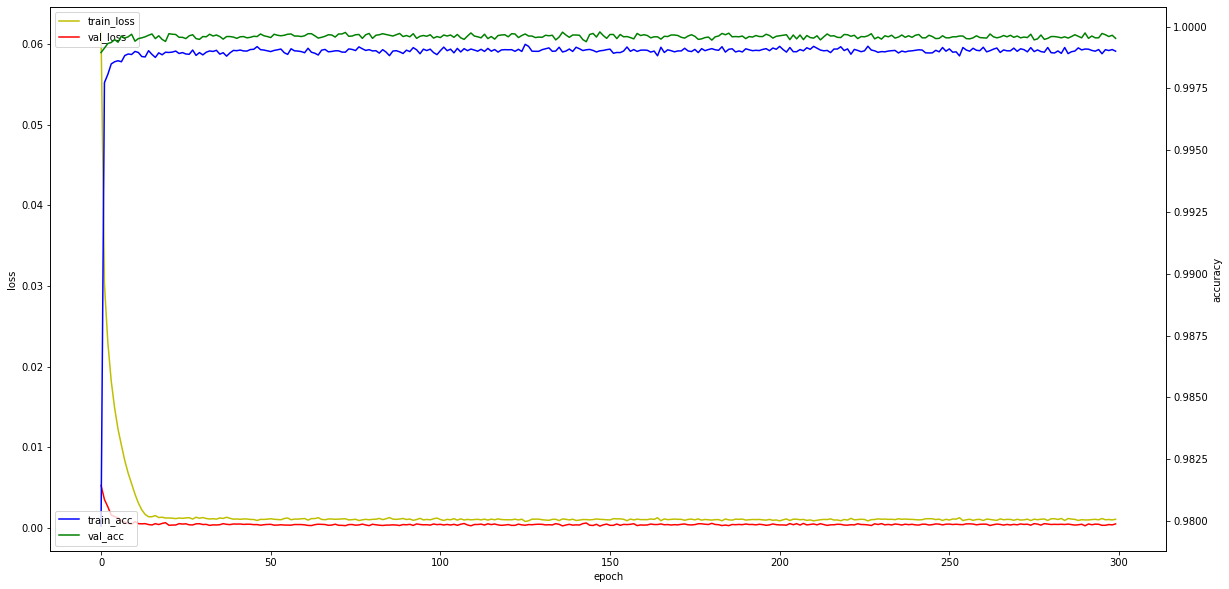

In [27]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [28]:
submit_df = pd.read_csv('./data/public_test.csv')

In [29]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited = parse_sentence(item.text)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2019-12-21 21:49:24.406221 0


In [30]:
test_conditioned = []
test_general = []

original_idx = []
for unknown in unknowns:
    conditioned = []
    general = []
    for item in unknown[:-1]:
        if item[1] == True:
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    test_conditioned.append(list(conditioned))
    test_general.append(list(general))
    original_idx.append(unknown[-1])

In [31]:
tidf_conditioned = vectorizer_conditioned.transform(test_conditioned).toarray()
tidf_general = vectorizer_general.transform(test_general).toarray()

In [32]:
pred_y = model.predict(x=[tidf_conditioned, tidf_general], verbose=1)

1626/1626 [==============================] - 0s 151us/step


In [33]:
pred_y[pred_y > 1.0] = 1.0

In [34]:
submit_df['smishing'] = np.abs(pred_y)

In [35]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20191221_3.csv', index=False)